In [ ]:
from  google.colab import drive
drive.mount('/content/drive',force_remount=True)
from google.colab.patches import cv2_imshow

Mounted at /content/drive


In [ ]:
import zipfile #zip 파일 풀 수 있게 하는 라이브러리
import os

#20만개 가까이 되는 사진이라 시간이 걸림
with zipfile.ZipFile("drive/MyDrive/img_align_celeba.zip") as zf:
  zf.extractall("drive/MyDrive") # 하위의 모든 폴더를 푸는 코드
  print("sucess")



sucess


In [ ]:
import glob #jpg 사진 전부를 한 번에 끌어들이기 위한 라이브러리
file_size = glob.glob("drive/MyDrive/img_align_celeba/*.jpg")
print(len(file_size)) #개수가 20만 장이 넘었다...


18290


In [ ]:
from PIL import Image
from keras.preprocessing import image
import matplotlib.pyplot as plt

dataset = [] # 10000개만 훈련하자
#print(len(file_size))


#glob를 이용해 벡터에 저장한 이미지들을 학습이 가능하게 숫자로 바꾸자!!!
for i in range(10000):
  im = Image.open(file_size[i])
  img2= im.resize((160,160))
  arr = image.img_to_array(img2)
  dataset.append(arr)
  if i%1000 ==0:
    print(i,"번째")




0 번째
1000 번째
2000 번째
3000 번째
4000 번째
5000 번째
6000 번째
7000 번째
8000 번째
9000 번째


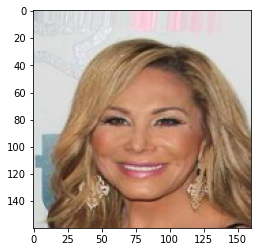

In [ ]:
#잘 벡터에 저장되었는지 확인
plt.imshow(image.array_to_img(dataset[len(dataset)-1]))

In [ ]:
import numpy as np

dataset=np.array(dataset)
print(dataset.shape)

(10000, 160, 160, 3)


In [ ]:
import keras
from keras import layers
import numpy as np

latent_dim = 50
height = 160
width = 160
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# 입력을 80 × 80 크기의 128개 채널을 가진 특성 맵으로 변환합니다
x = layers.Dense(128 * 40 * 40)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((40, 40, 128))(x)

# 합성곱 층을 추가합니다
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 80 × 80 크기로 업샘플링합니다
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# 합성곱 층을 더 추가합니다
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 160 × 160 크기로 업샘플링합니다
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# 합성곱 층을 더 추가합니다
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 160 × 160 크기의 1개 채널을 가진 특성 맵을 생성합니다
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense (Dense)                (None, 204800)            10444800  
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 204800)            0         
_________________________________________________________________
reshape (Reshape)            (None, 40, 40, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 40, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 40, 40, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 80, 80, 256)       104883

In [ ]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# 드롭아웃 층을 넣는 것이 아주 중요합니다!
x = layers.Dropout(0.4)(x)

# 분류 층
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# 옵티마이저에서 (값을 지정하여) 그래디언트 클리핑을 사용합니다
# 안정된 훈련을 위해서 학습률 감쇠를 사용합니다
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 158, 158, 128)     3584      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 158, 158, 128)     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 78, 78, 128)       262272    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 78, 78, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 38, 38, 128)       262272    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 38, 38, 128)       0   

In [ ]:
# 판별자의 가중치가 훈련되지 않도록 설정합니다(gan 모델에만 적용됩니다)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [ ]:
#dataset은 이미지 10000개가 담긴 것
x_train = dataset.reshape(
    (dataset.shape[0],) + (height,width,channels)).astype('float32')/255.


In [ ]:
import time

iterations = 10000
batch_size = 20
'''
save_dir = './datasets/gan_images/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
'''
new_img =[]
real_img = []
g_loss_list=[]
d_loss_list=[]


# 훈련 반복 시작
start = 0
for step in range(iterations):
    #한 epoch당 시간을 재보자
    cur_time = time.time()

    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 가짜 이미지를 디코딩합니다
    generated_images = generator.predict(random_latent_vectors)

    # 진짜 이미지와 연결합니다
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # 진짜와 가짜 이미지를 구분하여 레이블을 합칩니다
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # 레이블에 랜덤 노이즈를 추가합니다. 아주 중요합니다!
    labels += 0.05 * np.random.random(labels.shape)

    # discriminator를 훈련합니다
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 모두 “진짜 이미지"라고 레이블을 만듭니다
    misleading_targets = np.zeros((batch_size, 1))

    # generator를 훈련합니다(gan 모델에서 discriminator의 가중치는 동결됩니다)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # 중간 중간 저장하고 그래프를 그립니다
    if step % 100 == 0:
        # 모델 가중치를 저장합니다
        gan.save_weights('gan.h5')

        # 측정 지표를 출력합니다
        
        print('스텝 %s에서 판별자 손실: %s' % (step, d_loss),end="   ")
        print('스텝 %s에서 적대적 손실: %s' % (step, a_loss))
        print("시간은 : ", time.time()-cur_time)
        d_loss_list.append(d_loss)
        g_loss_list.append(a_loss)
        
        # 생성된 이미지들을 저장합니다
        new_img.append(generated_images[0] * 255.)
        # 비교를 위해 진짜 이미지역시 저장합니다
        real_img. append(real_images[0] * 255.)
       
      


In [ ]:
plt.plot(step,d_loss_list, "ro")
plt.title("discriminator")
plt.figure()
plt.plot(step,g_loss_list,"b")
plt.title("generator")
plt.show()

100 <class 'list'> (100, 170, 170, 3)


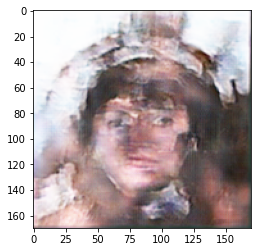

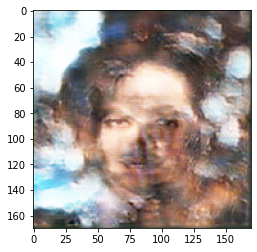

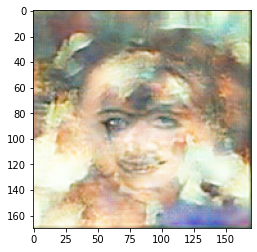

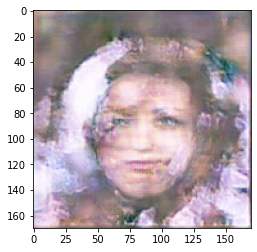

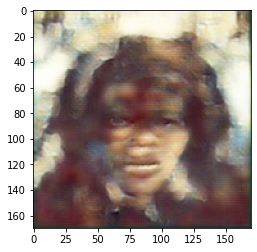

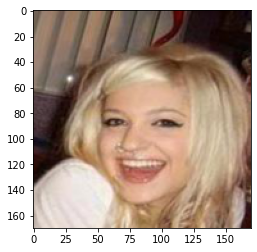

In [ ]:
a= np.array(new_img)
print(len(new_img),type(new_img),a.shape)
#print(a[99])
for i in range(90,95):
  plt.imshow(image.array_to_img(a[i]))
  plt.figure()
plt.imshow(image.array_to_img(real_img[99]))
